<a href="https://colab.research.google.com/github/kampuzzle/IA-T1/blob/main/PaulaBremenkampT1AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Aluna: Paula Um Porto de Azeredo Bremenkamp
* Matrícula: 2020100794

In [2]:
# utils 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random 
from collections import Counter
from scipy.stats import mode
import warnings
import seaborn as sns

# sklearn utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [3]:
warnings.filterwarnings("ignore")

# import da base de dados
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";")

df.set_index('id',inplace=True) #Transformando a coluna id no indice da tabela

#Observem que a classe esta separada em duas colunas então devemos concatenadas para formar uma coluna só chamada classe
df['classe'] = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 


## Seleção dos dados de acordo com a matrícula

In [4]:
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']
data = df[HARALICK + ['classe']]
df[HARALICK] = df[HARALICK].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
print(list(df[HARALICK].dtypes))

data.head(5)

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


,probmax,energia,entropia,contraste,homogeneidade,correlacao,classe
id,,,,,,,
355,"0,890374128851521","3,17034178175013","6,5716176171224","-30,7129899022437","3,76304934586401","0,00030352446061056",metalica400
356,"0,874335002692948","3,05605231787486","7,56143396285353","-37,1051952158663","3,72262223245045","0,000268692571829909",metalica400
357,"0,88498796746712","3,13069373707728","6,85342760134283","-27,9068889939748","3,74882866962454","0,000232954297907698",metalica400
358,"0,7646646581833","2,32154862004449","13,8784307675733","-109,018789473973","3,42956382241494","0,000166201729869237",metalica400
359,"0,897764519281096","3,22179527617412","6,21806574418637","-54,8235378125258","3,77587702004172","0,000259598389119525",metalica400


In [5]:
X = data[HARALICK]
y = data['classe']
X = X.replace(',', '.', regex=True).astype(float)


## Funções de uso geral

In [6]:
def estatisticas(scores, metodo): 
  media = np.mean(scores)
  desvio_padrao = np.std(scores)
  inf, sup = stats.norm.interval(0.95, loc=media, scale=desvio_padrao/np.sqrt(len(scores)))

  return {'Método': metodo, 'Média': media, 'Desvio Padrão': desvio_padrao, 'Limite Inferior': inf, 'Limite Superior': sup}


In [7]:
def treinamento(parametros, metodo):
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('metodo', metodo)]) # normalizacao
    clf = GridSearchCV(pipe, parametros, cv=4) # busca em grade com ciclo interno 4 folds
    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234) # 3 repetições e 10 folds

    return cross_val_score(clf, X, y, cv=rkf)


## ZeroR (ZR)

In [8]:
# Dummy classifier - 3 rodadas de validação cruzada estratificada de 10 folds do classificador
ZR = DummyClassifier()
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)
scoresZR = cross_val_score(ZR, X, y, scoring='accuracy', cv = rkf)

print (scoresZR)

[0.16666667 0.13333333 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.17241379 0.17241379 0.17241379 0.16666667 0.13333333
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.17241379
 0.17241379 0.17241379 0.16666667 0.13333333 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.17241379 0.17241379 0.17241379]


In [9]:
resultados = []
resultados.append(estatisticas(scoresZR, 'ZR'))

## Bagging (BA)

In [10]:
BA = BaggingClassifier(random_state=11)
parameters = {'metodo__n_estimators': [3, 9, 15, 21]} # setando hiperparâmetros
scoresBA = treinamento(parameters, BA)

print(scoresBA)

[0.76666667 0.43333333 0.53333333 0.56666667 0.63333333 0.56666667
 0.6        0.65517241 0.55172414 0.68965517 0.36666667 0.46666667
 0.63333333 0.66666667 0.56666667 0.53333333 0.53333333 0.65517241
 0.62068966 0.62068966 0.53333333 0.53333333 0.6        0.46666667
 0.6        0.5        0.6        0.44827586 0.68965517 0.62068966]


In [11]:
resultados.append(estatisticas(scoresBA, 'BA'))

## AdaBoost (AB)

In [12]:
AB = AdaBoostClassifier(random_state=11)
parameters = {'metodo__n_estimators':[3, 9, 15, 21]} # setando hiperparametros
scoresAB = treinamento(parameters, AB)

scoresAB

array([0.33333333, 0.26666667, 0.33333333, 0.36666667, 0.33333333,
       0.33333333, 0.3       , 0.34482759, 0.34482759, 0.34482759,
       0.3       , 0.33333333, 0.36666667, 0.36666667, 0.26666667,
       0.4       , 0.33333333, 0.34482759, 0.37931034, 0.34482759,
       0.36666667, 0.26666667, 0.36666667, 0.36666667, 0.33333333,
       0.3       , 0.33333333, 0.34482759, 0.34482759, 0.34482759])

In [13]:
resultados.append(estatisticas(scoresAB, 'AB'))

## RandomForest (RF)

In [14]:
rF = RandomForestClassifier(random_state=11)
parameters={'metodo__n_estimators': [3, 9, 15, 21]}
scoresRF = treinamento(parameters, rF)

scoresRF

array([0.76666667, 0.3       , 0.66666667, 0.53333333, 0.6       ,
       0.66666667, 0.66666667, 0.62068966, 0.51724138, 0.68965517,
       0.4       , 0.46666667, 0.73333333, 0.63333333, 0.53333333,
       0.6       , 0.63333333, 0.65517241, 0.5862069 , 0.62068966,
       0.6       , 0.56666667, 0.73333333, 0.53333333, 0.6       ,
       0.46666667, 0.56666667, 0.48275862, 0.5862069 , 0.5862069 ])

In [15]:
resultados.append(estatisticas(scoresRF, 'RF'))

## Heterogeneous Pooling (HP)

In [16]:
# retorna a ordenacao das classes de acordo com a ocorrencia nos exemplos na base de treino
def get_ordenacao(y_train):
  class_counts = Counter(y_train) # contagem de ocorrencias
  class_order = sorted(class_counts, key=class_counts.get, reverse=True) # ordenacao

  return class_order

In [17]:
# treina um modelo de acordo com o nome passado por parametro
def train_classificador(X_train, y_train, classifier_name):
  if classifier_name == 'KNN':
    classifier = KNeighborsClassifier()
  elif classifier_name == 'NB':
    classifier = GaussianNB()
  elif classifier_name == 'DT':
    classifier = DecisionTreeClassifier()
  
  classifier.fit(X_train, y_train)
  return classifier


In [19]:
class HeterogeneousPolling(BaseEstimator):
  def __init__(self, bias=None):
    super().__init__()
    self.bias = bias
    self.rl = []
    self.nclass = 0 
    self.combined_classifiers = []

  def fit(self,X,y):
    n_samples = [1, 3, 5, 7]
    classifier_names = ['KNN', 'NB', 'DT']
    class_order = get_ordenacao(y) # Chama funcao para ordenar as classes por ocorrencia 
    random_state = 0

    for n in n_samples:
      if n == 1:
        X_curr_train = X
        y_curr_train = y
      else:
        X_curr_train, y_curr_train = resample(X, y, random_state=random_state, replace=True) # resample da base de dados usando valor incremental do random state
        random_state += 1  # Incrementar o valor de random_state para a próxima iteração

      for classifier_name in classifier_names:
          classifier = train_classificador(X_curr_train, y_curr_train, classifier_name)
          self.combined_classifiers.append(classifier)

  def predict(self, X):
        y_pred = []
        # Faz a predicao de cada classificador no array e salva em y_pred
        for classifier in self.combined_classifiers:
            y_pred_single = classifier.predict(X)
            y_pred.append(y_pred_single)

        y_pred = np.array(y_pred)
        y_pred_majority, _ = mode(y_pred, axis=0) # Faz a moda entre as classes pra definir qual foi a mais votada

        # Lida com possíveis empates
        if y_pred_majority.shape[0] > 1:
            # Retorna a classe mais frequente na base de treino dentre as que empataram
            unique_classes, counts = np.unique(y_pred_majority, return_counts=True)
            most_frequent_class = unique_classes[np.argmax(counts)]
            y_pred_majority = most_frequent_class
        else:
            y_pred_majority = y_pred_majority[0]

        return y_pred_majority        

In [20]:
HP = HeterogeneousPolling()

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', HP)])

grade={'estimator__bias': [1, 3, 5, 7]}

gs = GridSearchCV(estimator=pipeline, param_grid = grade, scoring='accuracy', cv = 4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234) # 3 repetições e 10 folds

scoresHP = cross_val_score(gs, X, y, scoring='accuracy', cv = rkf)

print(scoresHP)

[0.76666667 0.5        0.7        0.46666667 0.53333333 0.6
 0.46666667 0.5862069  0.48275862 0.65517241 0.56666667 0.46666667
 0.6        0.73333333 0.53333333 0.6        0.63333333 0.68965517
 0.48275862 0.55172414 0.53333333 0.56666667 0.63333333 0.6
 0.53333333 0.5        0.63333333 0.48275862 0.68965517 0.62068966]


In [21]:
resultados.append(estatisticas(scoresHP, 'HP'))

## Resultados

In [22]:
tabela = pd.DataFrame(resultados)
tabela.set_index('Método',inplace=True)

tabela

           Média  Desvio Padrão  Limite Inferior  Limite Superior
Método                                                           
ZR      0.165057       0.010883         0.161163         0.168952
BA      0.575057       0.085228         0.544560         0.605555
AB      0.336820       0.031929         0.325394         0.348245
RF      0.587050       0.097992         0.551985         0.622115
HP      0.580268       0.082431         0.550771         0.609765


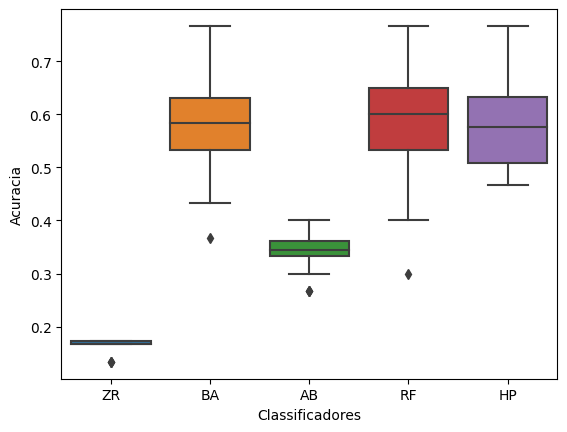

In [26]:
modelos = ["ZR", "BA", "AB", "RF", "HP"]
scores = [scoresZR, scoresBA, scoresAB, scoresRF, scoresHP]
sns.boxplot(data=scores).set(xticklabels=modelos)
plt.xlabel('Classificadores')
plt.ylabel("Acuracia")


In [28]:

# Realizar os testes de hipótese
t_pvalues = []
wilcoxon_pvalues = []

for i in range(len(modelos)):
    for j in range(i+1, len(modelos)):
        t_result = stats.ttest_rel(scores[i], scores[j])
        t_pvalues.append(t_result.pvalue)

        wilcoxon_result = stats.wilcoxon(scores[i], scores[j])
        wilcoxon_pvalues.append(wilcoxon_result.pvalue)

# Criar a tabela pareada
tabela_pareada = pd.DataFrame(index=modelos, columns=modelos)

# Preencher a matriz triangular superior com os resultados do teste t pareado
for i in range(len(modelos)):
    for j in range(i+1, len(modelos)):
        if t_pvalues[0] < 0.05:
            tabela_pareada.iloc[i, j] = f'{t_pvalues[0]:.3f}'
        else:
            tabela_pareada.iloc[i, j] = f'{t_pvalues[0]:.6f}'
        t_pvalues.pop(0)

# Preencher a matriz triangular inferior com os resultados do teste de Wilcoxon
for i in range(len(modelos)):
    for j in range(i):
        if wilcoxon_pvalues[0] < 0.05:
            tabela_pareada.iloc[i, j] = f'{wilcoxon_pvalues[0]:.3f}'
        else:
            tabela_pareada.iloc[i, j] = f'{wilcoxon_pvalues[0]:.6f}'
        wilcoxon_pvalues.pop(0)

# Exibir a tabela pareada
tabela_pareada

,ZR,BA,AB,RF,HP
ZR,NaN,0.000,0.000,0.000,0.000
BA,0.000,NaN,0.000,0.320223,0.729534
AB,0.000,0.000,NaN,0.000,0.000
RF,0.000,0.000,0.288643,NaN,0.665420
HP,0.988572,0.000,0.000,0.492056,NaN
